In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

In [3]:
data = pd.read_csv('adult.csv')

In [4]:
data.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
data = data.replace('?', np.nan)

In [7]:
# Define features and target
numerical_features = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
categorical_features = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
target = 'income'

In [8]:
# Handle missing values: drop rows with NaN in target, fill categorical with mode, numerical with median
data = data.dropna(subset=[target])
for col in categorical_features:
    data[col] = data[col].fillna(data[col].mode()[0])
for col in numerical_features:
    data[col] = data[col].fillna(data[col].median())

In [9]:
# Encode target variable (<=50K=0, >50K=1)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data[target])

In [10]:
# Features
X = data[numerical_features + categorical_features]

# Check skewness in numerical features
print("Skewness of numerical features:")
print(X[numerical_features].skew())

Skewness of numerical features:
age                0.558743
fnlwgt             1.446980
education.num     -0.311676
capital.gain      11.953848
capital.loss       4.594629
hours.per.week     0.227643
dtype: float64


In [12]:
# Apply log transformation to highly skewed features (skewness > 1)
for col in numerical_features:
    if X[col].skew() > 1:
        X[col] = np.log1p(X[col])

/tmp/ipykernel_11567/895741918.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.log1p(X[col])


In [13]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Preprocessing pipeline
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [15]:
# Fit and transform training data, transform test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (26048, 97)
Testing set shape: (6513, 97)


In [16]:
# Define the Keras model with regularization
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

I0000 00:00:1750460638.171918   11567 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,913 (89.50 KB)

 Trainable params: 22,913 (89.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose=1)

Epoch 1/50


I0000 00:00:1750460652.709046   11784 service.cc:152] XLA service 0x7f893400b3c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750460652.709084   11784 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-06-21 04:34:12.734965: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750460652.953552   11784 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/326 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4129 - loss: 3.0119

I0000 00:00:1750460654.082786   11784 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7531 - loss: 1.6160

2025-06-21 04:34:16.891677: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 8 bytes spill stores, 8 bytes spill loads

2025-06-21 04:34:16.900435: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 12 bytes spill stores, 12 bytes spill loads

2025-06-21 04:34:17.193200: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 112 bytes spill stores, 112 bytes spill loads

2025-06-21 04:34:18.528971: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 12 bytes spill stores, 12 bytes spill loads

2025-06-21 04:34:18.747494: I external/local_xla

326/326 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.7532 - loss: 1.6141 - val_accuracy: 0.8501 - val_loss: 0.4302
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8387 - loss: 0.4334 - val_accuracy: 0.8136 - val_loss: 0.4268
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8372 - loss: 0.4099 - val_accuracy: 0.8501 - val_loss: 0.3778
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8431 - loss: 0.3963 - val_accuracy: 0.8497 - val_loss: 0.3717
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8403 - loss: 0.3900 - val_accuracy: 0.8514 - val_loss: 0.3700
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8360 - loss: 0.3889 - val_accuracy: 0.8499 - val_loss: 0.3699
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8381 - loss: 0.3883 - val_accuracy: 0.8495 - val_loss: 0.3660
Epoch 8/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8363 - loss: 0.3877 - val_accuracy: 0.8516 - val

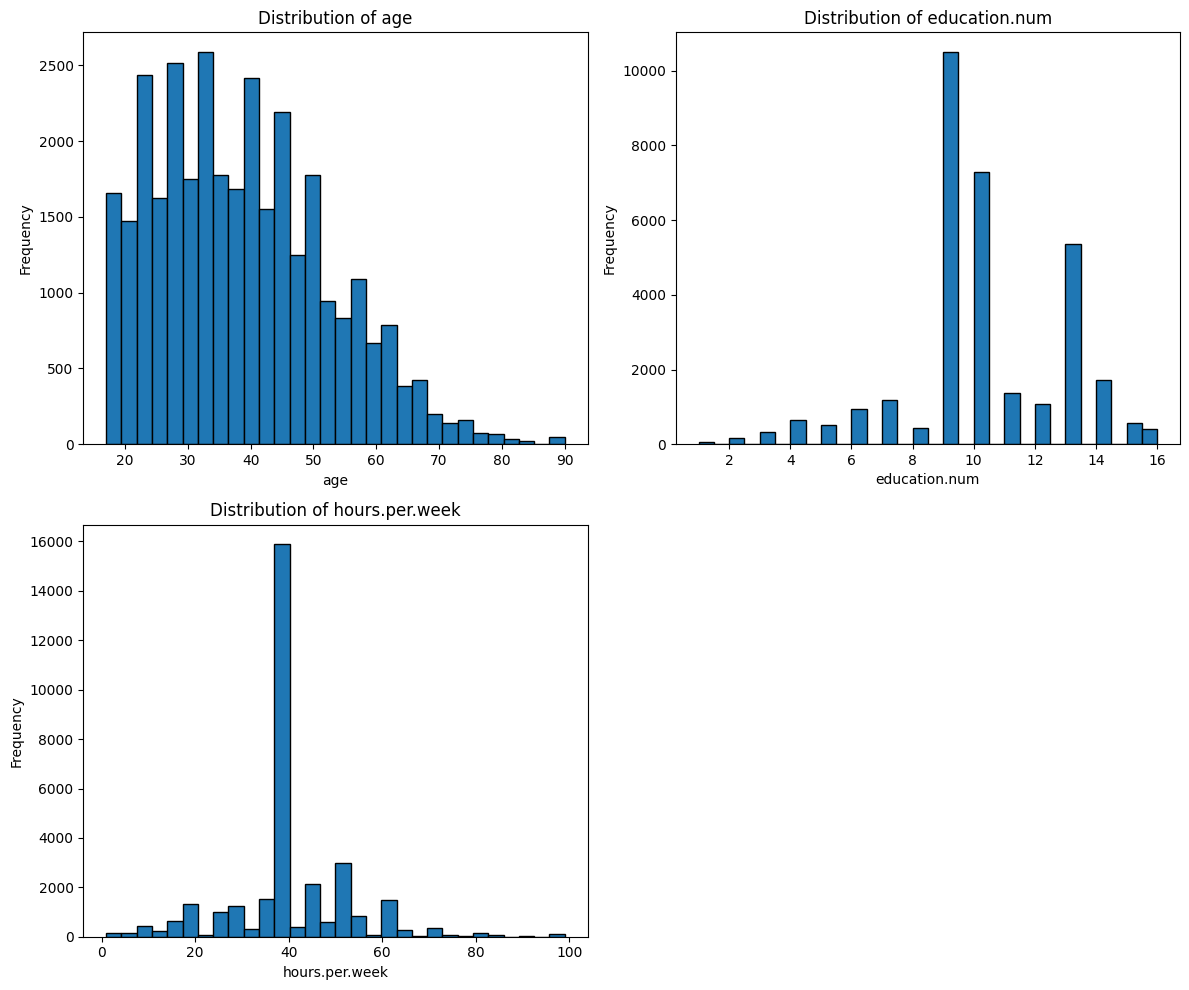

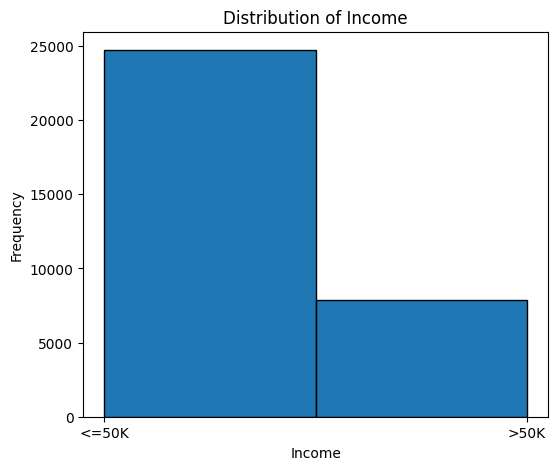

In [19]:
# Plot histograms for selected numerical features
plt.figure(figsize=(12, 10))
features_to_plot = ['age', 'education.num', 'hours.per.week']
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(data[feature], bins=30, edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Plot target distribution
plt.figure(figsize=(6, 5))
plt.hist(data[target], bins=2, edgecolor='black')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.show()

In [20]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
predictions = model.predict(X_test, verbose=0)
predictions_binary = (predictions > 0.5).astype(int)

2025-06-21 04:35:37.747867: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 12 bytes spill stores, 12 bytes spill loads

2025-06-21 04:35:38.063582: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 4 bytes spill stores, 4 bytes spill loads

2025-06-21 04:35:39.422714: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 12 bytes spill stores, 12 bytes spill loads

2025-06-21 04:35:39.609440: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_53', 4 bytes spill stores, 4 bytes spill loads



In [21]:
# Calculate additional metrics
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions_binary)

print(f"Test Loss (Binary Crossentropy): {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.2f}")

Test Loss (Binary Crossentropy): 0.3608
Test Accuracy: 0.8402
Test MSE: 0.1076
Test MAE: 0.2159
R² Score: 0.11


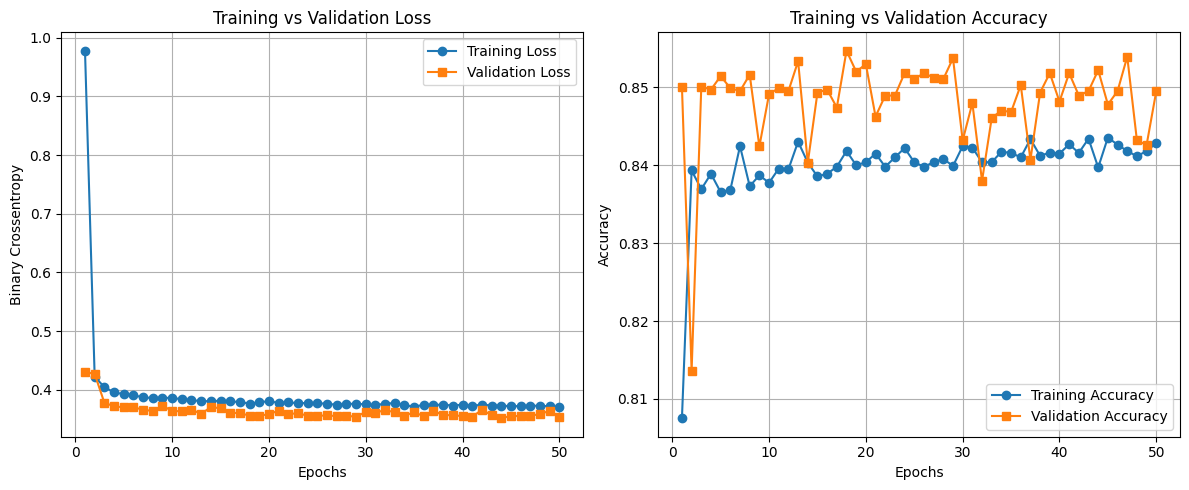

In [22]:
# Plot training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 's-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc, 's-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

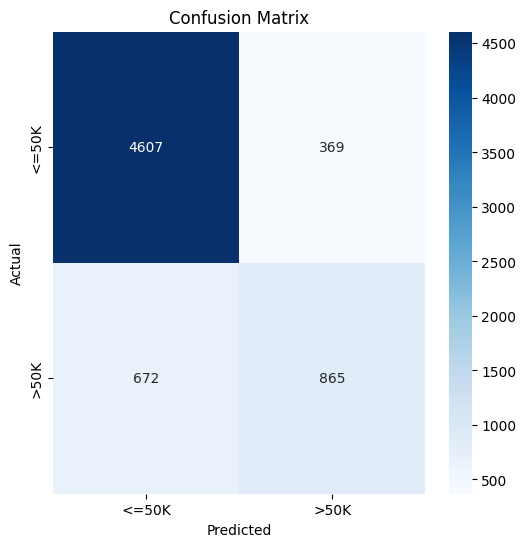

In [23]:
# Plot confusion matrix
cm = confusion_matrix(y_test, predictions_binary)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()